In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_excel('../1_data/RNL Deposits 2016-2019.xlsx')
data.head()

,InstitutionName,StudentId,AcademicYearAndTerm,Entry_Stat,MatrixPopName,Date_Adm,Date_Canc,Date_Con
0,Loyola University New Orleans,131839,16171,1,First-Year Out-of-State excl Athlete,NaT,NaT,NaT
1,Loyola University New Orleans,166273,16171,1,First-Year Out-of-State excl Athlete,NaT,NaT,NaT
2,Loyola University New Orleans,729579,16171,1,First-Year Out-of-State excl Athlete,NaT,NaT,NaT
3,Loyola University New Orleans,954530,16171,1,First-Year Out-of-State excl Athlete,NaT,NaT,NaT
4,Loyola University New Orleans,1028268,16171,1,First-Year Out-of-State excl Athlete,NaT,NaT,NaT


In [3]:
data['Entry_Stat'].value_counts(dropna=False)

1    12076
F     3418
2      650
T      190
Name: Entry_Stat, dtype: int64

In [4]:
#keep only freshmen
transfer = data[(data['Entry_Stat']=='T') | (data['Entry_Stat']=='2')]
freshmen = data[(data['Entry_Stat']=='F') | (data['Entry_Stat']=='1')]

In [5]:
print(freshmen['StudentId'].count())
freshmen = freshmen[pd.notna(data['Date_Con'])]
print(freshmen['StudentId'].count())

15494
3278


In [6]:
freshmen['AcademicYearAndTerm'].value_counts(dropna=False)

19201    899
17181    858
18191    840
16171    681
Name: AcademicYearAndTerm, dtype: int64

In [7]:
freshmen2 = freshmen[pd.isna(freshmen['Date_Canc'])]
print(freshmen2['StudentId'].count())

3068


In [8]:
freshmen2['StudentId'].count()/freshmen['StudentId'].count()

0.9359365466748018

In [9]:
freshmen['Date_Con']=pd.to_datetime(freshmen['Date_Con'])
freshmen['Date_Con'].describe()

count                    3278
unique                    602
top       2019-04-30 00:00:00
freq                       86
first     2016-01-04 00:00:00
last      2019-08-21 00:00:00
Name: Date_Con, dtype: object

In [10]:
freshmen['canc']=1
freshmen['canc'][pd.isna(freshmen['Date_Canc'])]=0
pd.crosstab(freshmen['AcademicYearAndTerm'], freshmen['canc'])

canc,0,1
AcademicYearAndTerm,,
16171,681,0
17181,801,57
18191,766,74
19201,820,79


In [11]:
print('Average Cancellation Rate over the Last three years')
print((57+74+79)/(801+766+820+57+74+79)*100)

Average Cancellation Rate over the Last three years
8.086253369272237


In [12]:
df=freshmen[freshmen['AcademicYearAndTerm']!=16171]
df=df[['Date_Con']]
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df['y']=1
df.rename(columns={'Date_Con':'ds'}, inplace=True)
df.head()

,ds,y
0,2017-07-20,1
1,2017-04-29,1
2,2017-07-05,1
3,2017-05-01,1
4,2017-05-02,1


In [13]:
df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

# Add 2020 data

In [14]:
df_20 = pd.read_excel('../1_data/RNL Deposits 2020.xlsx')
df_20_T = df_20[df_20['Entry_Stat']=='T']
df_20 = df_20[df_20['Entry_Stat']!='T']
df_20=df_20[['Date_Con']]
df_20['y']=1
df_20['ds']=pd.to_datetime(df_20['Date_Con'])
df_20.drop('Date_Con', axis=1, inplace=True)
df_20.head()

,y,ds
1,1,2019-05-01
2,1,2019-04-29
3,1,2019-03-28
4,1,2020-02-27
5,1,2020-02-20


In [15]:
df_20['y'].count()

162

In [16]:
print(df['y'].count())
df = df.append(df_20)
print(df['y'].count())

2597
2759


In [17]:
df['x']='x'
week = df.groupby("x").resample('W-Wed', label='right', closed = 'right', on='ds').sum().reset_index().sort_values(by='ds')
week.drop('x',axis=1, inplace=True)
week.head()

,ds,y
0,2016-12-07,1
1,2016-12-14,3
2,2016-12-21,3
3,2016-12-28,0
4,2017-01-04,9


In [18]:
week.tail()

,ds,y
166,2020-02-12,7
167,2020-02-19,13
168,2020-02-26,23
169,2020-03-04,24
170,2020-03-11,29


# Past Three year data + 2020 current

In [19]:
my_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
#my_model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
my_model.fit(week)

##### UPDATE NEXT LINE ####
future_dates = my_model.make_future_dataframe(periods=23, freq='w')
###########################

forecast = my_model.predict(future_dates)
print(forecast['yhat'][forecast['ds'] >= '2019-09-01'].sum())
print(forecast['yhat'][(forecast['ds'] > '2019-09-01') & (forecast['ds'] < '2020-07-31')].sum())

###### UPDATE NEXT LINE #########
print(forecast['yhat'][(forecast['ds'] > '2019-09-01') & (forecast['ds'] < '2020-03-21')].sum())

802.3012964828562
817.1649105247225
192.83154713709843


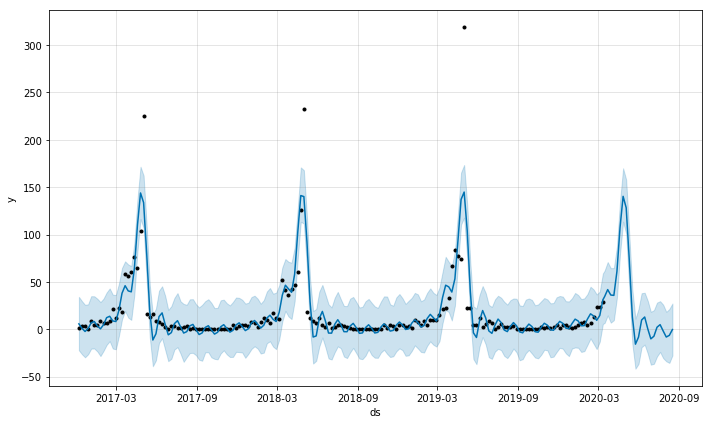

In [20]:
my_model.plot(forecast, uncertainty=True);

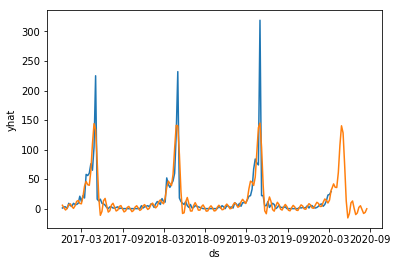

In [21]:
sns.lineplot(x='ds', y='y', data=week)
sns.lineplot(x='ds', y='yhat', data=forecast)

In [22]:
week['week_number']=week['ds'].dt.week
week.head(20)

,ds,y,week_number
0,2016-12-07,1,49
1,2016-12-14,3,50
2,2016-12-21,3,51
3,2016-12-28,0,52
4,2017-01-04,9,1
5,2017-01-11,5,2
6,2017-01-18,4,3
7,2017-01-25,9,4
8,2017-02-01,7,5
9,2017-02-08,7,6


In [23]:
week.drop('week_number', inplace =True, axis=1)
week.head()

,ds,y
0,2016-12-07,1
1,2016-12-14,3
2,2016-12-21,3
3,2016-12-28,0
4,2017-01-04,9


In [24]:
def is_dep_season(ds):
    date = pd.to_datetime(ds)
    return (date.week > 8 or date.week < 19)

week['on_season'] = week['ds'].apply(is_dep_season)
week['off_season'] = ~week['ds'].apply(is_dep_season)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


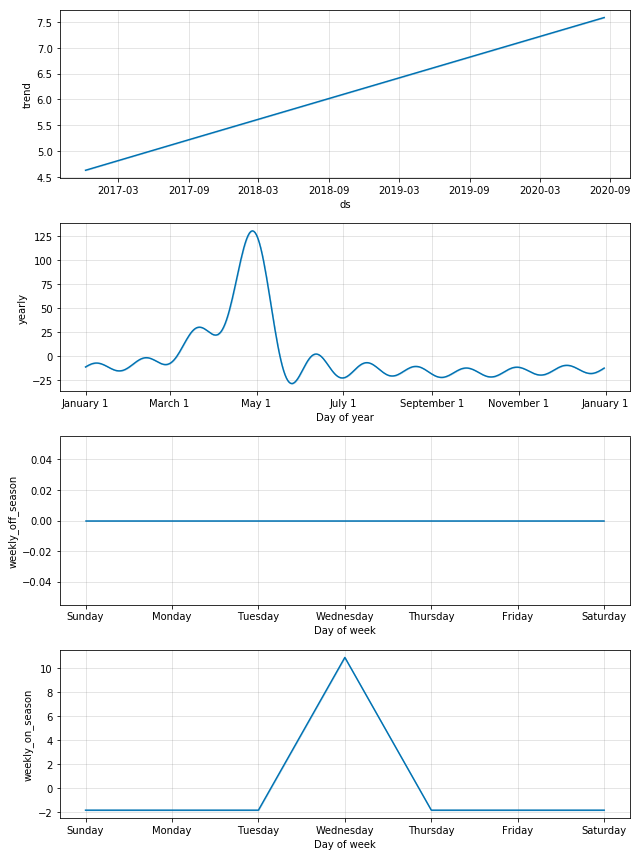

In [25]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
m.fit(week)

##### UPDATE NEXT LINE ####
future = m.make_future_dataframe(periods=23, freq='w')
###########################

future['on_season'] = future['ds'].apply(is_dep_season)
future['off_season'] = ~future['ds'].apply(is_dep_season)

forecast = m.predict(future)

fig = m.plot_components(forecast)

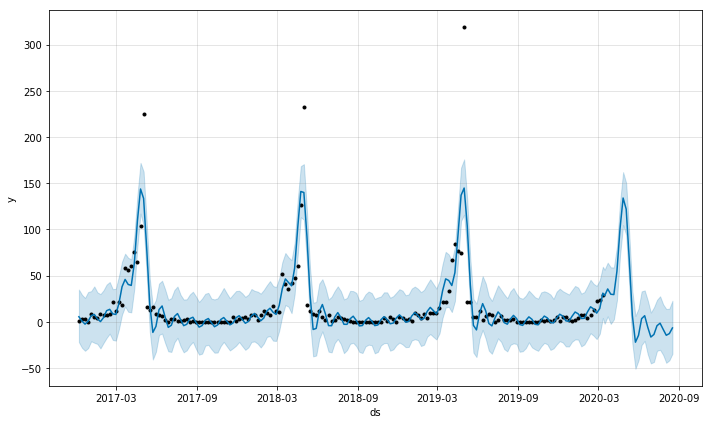

In [26]:
m.plot(forecast);

In [27]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly_off_season,weekly_off_season_lower,weekly_off_season_upper,weekly_on_season,weekly_on_season_lower,weekly_on_season_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-07,4.624959,-21.865087,35.033575,4.624959,4.624959,0.976394,0.976394,0.976394,0.0,0.0,0.0,10.878366,10.878366,10.878366,-9.901973,-9.901973,-9.901973,0.0,0.0,0.0,5.601352
1,2016-12-14,4.640456,-27.962659,29.363010,4.640456,4.640456,-3.645046,-3.645046,-3.645046,0.0,0.0,0.0,10.878366,10.878366,10.878366,-14.523413,-14.523413,-14.523413,0.0,0.0,0.0,0.995410
2,2016-12-21,4.655953,-31.243379,25.925181,4.655953,4.655953,-7.078333,-7.078333,-7.078333,0.0,0.0,0.0,10.878366,10.878366,10.878366,-17.956699,-17.956699,-17.956699,0.0,0.0,0.0,-2.422380
3,2016-12-28,4.671450,-28.342478,32.303002,4.671450,4.671450,-3.961858,-3.961858,-3.961858,0.0,0.0,0.0,10.878366,10.878366,10.878366,-14.840224,-14.840224,-14.840224,0.0,0.0,0.0,0.709592
4,2017-01-04,4.686947,-20.917000,33.277090,4.686947,4.686947,2.115504,2.115504,2.115504,0.0,0.0,0.0,10.878366,10.878366,10.878366,-8.762863,-8.762863,-8.762863,0.0,0.0,0.0,6.802451


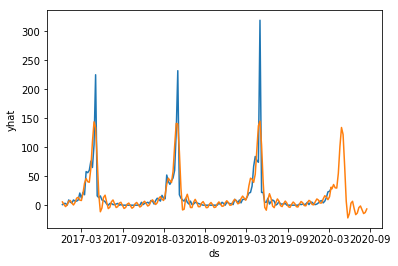

In [28]:
sns.lineplot(x='ds', y='y', data=week)
sns.lineplot(x='ds', y='yhat', data=forecast)

In [29]:
print(forecast['yhat'][forecast['ds'] > '2019-09-01'].sum())
print(forecast['yhat'][(forecast['ds'] > '2019-09-01') & (forecast['ds'] < '2020-07-31')].sum())

658.783487844276
692.4148810913011


# Two Year Data

In [30]:
print(week['ds'].count())
week2 = week[week['ds']>='2017-08-31']
print(week2['ds'].count())

171
132


In [31]:
my_model2 = Prophet(weekly_seasonality=True, daily_seasonality=True)
#my_model2.add_seasonality(name='monthly', period=30.5, fourier_order=20)
my_model2.fit(week2)

########### UPDATE NEXT LINE ###########
future_dates2 = my_model2.make_future_dataframe(periods=23, freq='w')
########################################

forecast2 = my_model2.predict(future_dates2)
print(forecast2['yhat'][forecast2['ds'] > '2019-09-01'].sum())
print(forecast2['yhat'][(forecast2['ds'] > '2019-09-01') & (forecast2['ds'] < '2020-07-31')].sum())

810.5537099600359
825.5959770092454


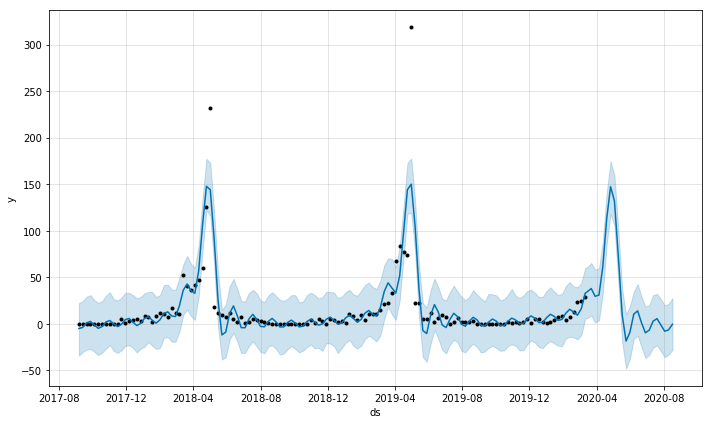

In [32]:
my_model2.plot(forecast2);

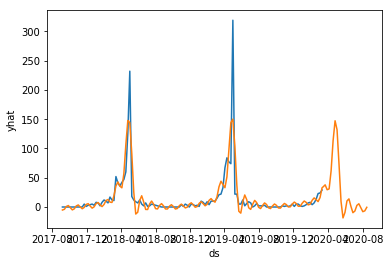

In [33]:
sns.lineplot(x='ds', y='y', data=week2)
sns.lineplot(x='ds', y='yhat', data=forecast2)

In [34]:
week2['on_season'] = week2['ds'].apply(is_dep_season)
week2['off_season'] = ~week2['ds'].apply(is_dep_season)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


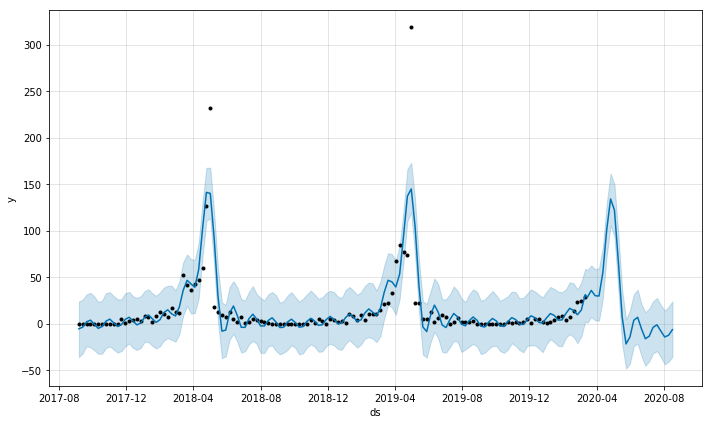

In [35]:
m2 = Prophet(weekly_seasonality=False)
m2.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m2.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')
m2.fit(week2)

########## UPDATE NEXT LINE Each Week #########
future2 = m2.make_future_dataframe(periods=23, freq='w')
#####################################

future2['on_season'] = future2['ds'].apply(is_dep_season)
future2['off_season'] = ~future2['ds'].apply(is_dep_season)

forecast2 = m.predict(future2)

m2.plot(forecast2);

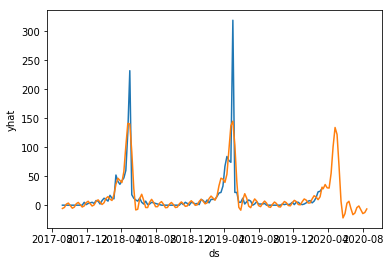

In [36]:
sns.lineplot(x='ds', y='y', data=week2)
sns.lineplot(x='ds', y='yhat', data=forecast2)

In [37]:
print(forecast2['yhat'][forecast2['ds'] > '2019-09-01'].sum())
print(forecast2['yhat'][(forecast2['ds'] > '2019-09-01') & (forecast2['ds'] < '2020-07-31')].sum())

658.783487844276
692.4148810913011


**The best overall model seems to be my_model2**.

Run my_model2 again

# My Model 2

In [38]:
my_model2 = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_prior_scale=5, 
                   n_changepoints=4)
my_model2.add_seasonality(name='monthly', period=30.5, fourier_order=7)
my_model2.fit(week2)

######### UPDATE NEXT LINE EACH WEEK ############
future_dates2 = my_model2.make_future_dataframe(periods=24, freq='w')
################################################

forecast2 = my_model2.predict(future_dates2)
forecast2['yhat'][forecast2['yhat']<0]=0
print(forecast2['yhat'][forecast2['ds'] > '2019-09-01'].sum())
print(forecast2['yhat'][(forecast2['ds'] > '2019-09-01') & (forecast2['ds'] < '2020-07-31')].sum())

894.0344084582506
884.1010237073092


In [39]:
print('Expected Enrollment (High)- based on 2019')
print(894*(820/899))

Expected Enrollment (High)- based on 2019
815.4393770856508


In [40]:
print('Expected Enrollment (Low)- based on 2019')
print(884*(820/899))

Expected Enrollment (Low)- based on 2019
806.3181312569521


In [41]:
print('Expected Enrollment (High)- based on 2 years')
print(894*(1-0.08))
print('Expected Enrollment (Low)- based on 2 years')
print(884*(1-0.08))

Expected Enrollment (High)- based on 2 years
822.48
Expected Enrollment (Low)- based on 2 years
813.2800000000001


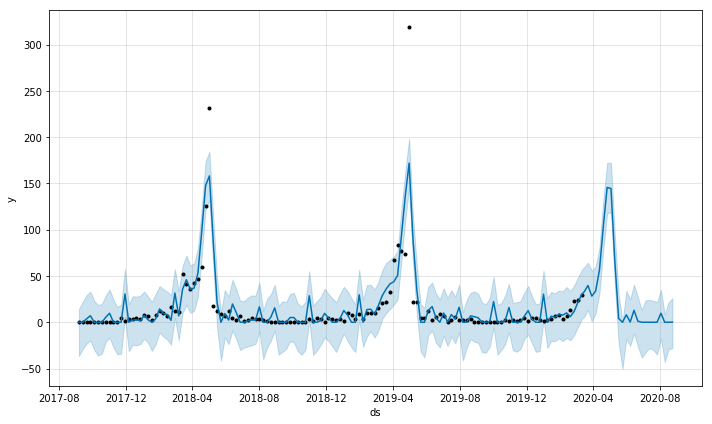

In [42]:
my_model2.plot(forecast2);

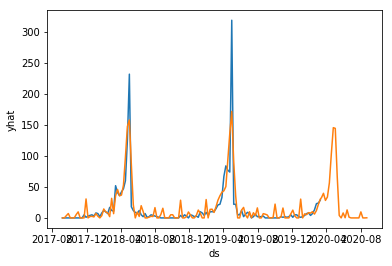

In [43]:
sns.lineplot(x='ds', y='y', data=week2)
sns.lineplot(x='ds', y='yhat', data=forecast2)

In [44]:
vars_req = forecast2[['ds', 'yhat']]
print(vars_req['ds'].count())
vars_req.head()

156


,ds,yhat
0,2017-09-06,0.000000
1,2017-09-13,0.000000
2,2017-09-20,3.697489
3,2017-09-27,7.081132
4,2017-10-04,0.000000


In [45]:
print(week2['ds'].count())
week2=week2[['ds', 'y']]
week2.head()

132


,ds,y
39,2017-09-06,0
40,2017-09-13,0
41,2017-09-20,0
42,2017-09-27,0
43,2017-10-04,0


In [46]:
final=vars_req.merge(week2, on='ds', how='left')
final['y'].value_counts(dropna=False)

0.0      31
NaN      24
2.0      15
5.0      11
1.0       9
4.0       8
7.0       7
3.0       6
12.0      5
10.0      5
8.0       4
22.0      3
9.0       3
6.0       2
11.0      1
41.0      1
52.0      1
24.0      1
17.0      1
42.0      1
36.0      1
60.0      1
47.0      1
23.0      1
29.0      1
232.0     1
18.0      1
15.0      1
21.0      1
33.0      1
67.0      1
84.0      1
77.0      1
74.0      1
319.0     1
13.0      1
126.0     1
Name: y, dtype: int64

In [47]:
# compare predicted to actuals
print('Actual 2018-19')
print(final['y'][(final['ds'] > '2018-08-31') & (final['ds'] < '2019-09-01')].sum())
print('Predicted 2018-19')
print(final['yhat'][(final['ds'] > '2018-08-31') & (final['ds'] < '2019-09-01')].sum())

Actual 2018-19
912.0
Predicted 2018-19
977.4224505099203


In [48]:
print('Actual 2017-18')
print(final['y'][(final['ds'] > '2017-08-31') & (final['ds'] < '2018-09-01')].sum())
print('Predicted 2017-18')
print(final['yhat'][(final['ds'] > '2017-08-31') & (final['ds'] < '2018-09-01')].sum())

Actual 2017-18
841.0
Predicted 2017-18
954.2073325640707


In [49]:
print('Actual 2019-20')
print(final['y'][(final['ds'] > '2019-08-31') & (final['ds'] < '2020-03-21')].sum()) #Today
print('Predicted 2019-20')
print(final['yhat'][(final['ds'] > '2019-08-31') & (final['ds'] < '2020-03-21')].sum()) #today

Actual 2019-20
148.0
Predicted 2019-20
239.6676289574404


In [50]:
final.head()

,ds,yhat,y
0,2017-09-06,0.000000,0.0
1,2017-09-13,0.000000,0.0
2,2017-09-20,3.697489,0.0
3,2017-09-27,7.081132,0.0
4,2017-10-04,0.000000,0.0


In [51]:
final.tail()

,ds,yhat,y
151,2020-07-26,0.000000,NaN
152,2020-08-02,9.745691,NaN
153,2020-08-09,0.000000,NaN
154,2020-08-16,0.000000,NaN
155,2020-08-23,0.187694,NaN


In [52]:
final.to_excel('../3_res/final_forecast.xlsx', index=False)

# Create dataset of actuals and predicted

In [53]:
fy18 = final[(final['ds'] > '2017-08-31') & (final['ds'] < '2018-09-01')]
fy18 = fy18[['ds', 'y', 'yhat']]
fy18.reset_index(inplace=True)
fy18['index']=fy18['index']+1
fy18.rename(columns={'index':'week'}, inplace = True)

fy19 = final[(final['ds'] > '2018-08-31') & (final['ds'] < '2019-09-01')]
fy19 = fy19[['ds', 'y', 'yhat']]
fy19.reset_index(inplace=True)
fy19['index']=fy19['index']+1 - 52
fy19.rename(columns={'index':'week'}, inplace=True)

fy20 = final[(final['ds'] > '2019-08-31') & (final['ds'] < '2020-09-01')]
fy20 = fy20[['ds', 'y', 'yhat']]
fy20.reset_index(inplace=True)
fy20['index']=fy20['index']+1 - 104
fy20.rename(columns={'index':'week'}, inplace=True)

In [54]:
fy18.head()

,week,ds,y,yhat
0,1,2017-09-06,0.0,0.000000
1,2,2017-09-13,0.0,0.000000
2,3,2017-09-20,0.0,3.697489
3,4,2017-09-27,0.0,7.081132
4,5,2017-10-04,0.0,0.000000


In [55]:
fy19.head()

,week,ds,y,yhat
0,1,2018-09-05,0.0,0.000000
1,2,2018-09-12,0.0,0.000000
2,3,2018-09-19,0.0,0.000000
3,4,2018-09-26,0.0,5.122209
4,5,2018-10-03,0.0,5.123459


In [56]:
fy20.head()

,week,ds,y,yhat
0,1,2019-09-04,0.0,4.779093
1,2,2019-09-11,0.0,0.000000
2,3,2019-09-18,0.0,0.000000
3,4,2019-09-25,0.0,0.747489
4,5,2019-10-02,0.0,22.308750


In [57]:
fy18['week'].count() - fy19['week'].count()

0

In [58]:
fy19['week'].count() - fy20['week'].count() #ok

0

In [59]:
comb = fy18.merge(fy19, on='week', how='left')
comb = comb.merge(fy20, on='week', how='left')
comb.head()

,week,ds_x,y_x,yhat_x,ds_y,y_y,yhat_y,ds,y,yhat
0,1,2017-09-06,0.0,0.000000,2018-09-05,0.0,0.000000,2019-09-04,0.0,4.779093
1,2,2017-09-13,0.0,0.000000,2018-09-12,0.0,0.000000,2019-09-11,0.0,0.000000
2,3,2017-09-20,0.0,3.697489,2018-09-19,0.0,0.000000,2019-09-18,0.0,0.000000
3,4,2017-09-27,0.0,7.081132,2018-09-26,0.0,5.122209,2019-09-25,0.0,0.747489
4,5,2017-10-04,0.0,0.000000,2018-10-03,0.0,5.123459,2019-10-02,0.0,22.308750


In [60]:
comb.rename(columns = {'ds_x':'week_2018', 'ds_y':'week_2019', 'ds':'week_2020', 'y_x':'dep_2018_act', 
                       'y_y':'dep_2019_act', 'y':'dep_2020_act', 'yhat_x':'dep_2018_pred', 'yhat_y':'dep_2019_pred', 
                      'yhat':'dep_2020_pred'}, inplace=True)
comb.head()

,week,week_2018,dep_2018_act,dep_2018_pred,week_2019,dep_2019_act,dep_2019_pred,week_2020,dep_2020_act,dep_2020_pred
0,1,2017-09-06,0.0,0.000000,2018-09-05,0.0,0.000000,2019-09-04,0.0,4.779093
1,2,2017-09-13,0.0,0.000000,2018-09-12,0.0,0.000000,2019-09-11,0.0,0.000000
2,3,2017-09-20,0.0,3.697489,2018-09-19,0.0,0.000000,2019-09-18,0.0,0.000000
3,4,2017-09-27,0.0,7.081132,2018-09-26,0.0,5.122209,2019-09-25,0.0,0.747489
4,5,2017-10-04,0.0,0.000000,2018-10-03,0.0,5.123459,2019-10-02,0.0,22.308750


In [61]:
x = ['dep_2018_act', 'dep_2019_act', 'dep_2020_act', 'dep_2018_pred', 'dep_2019_pred', 'dep_2020_pred']
for i in x:
    comb[i+'_cum']=comb[i].cumsum()

comb.head()

,week,week_2018,dep_2018_act,dep_2018_pred,week_2019,dep_2019_act,dep_2019_pred,week_2020,dep_2020_act,dep_2020_pred,dep_2018_act_cum,dep_2019_act_cum,dep_2020_act_cum,dep_2018_pred_cum,dep_2019_pred_cum,dep_2020_pred_cum
0,1,2017-09-06,0.0,0.000000,2018-09-05,0.0,0.000000,2019-09-04,0.0,4.779093,0.0,0.0,0.0,0.000000,0.000000,4.779093
1,2,2017-09-13,0.0,0.000000,2018-09-12,0.0,0.000000,2019-09-11,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,4.779093
2,3,2017-09-20,0.0,3.697489,2018-09-19,0.0,0.000000,2019-09-18,0.0,0.000000,0.0,0.0,0.0,3.697489,0.000000,4.779093
3,4,2017-09-27,0.0,7.081132,2018-09-26,0.0,5.122209,2019-09-25,0.0,0.747489,0.0,0.0,0.0,10.778622,5.122209,5.526582
4,5,2017-10-04,0.0,0.000000,2018-10-03,0.0,5.123459,2019-10-02,0.0,22.308750,0.0,0.0,0.0,10.778622,10.245667,27.835332


In [62]:
z = ['dep_2018_pred_cum', 'dep_2019_pred_cum', 'dep_2020_pred_cum']

for i in z:
    comb[i+'']=comb[i+''].round()

comb.head()

,week,week_2018,dep_2018_act,dep_2018_pred,week_2019,dep_2019_act,dep_2019_pred,week_2020,dep_2020_act,dep_2020_pred,dep_2018_act_cum,dep_2019_act_cum,dep_2020_act_cum,dep_2018_pred_cum,dep_2019_pred_cum,dep_2020_pred_cum
0,1,2017-09-06,0.0,0.000000,2018-09-05,0.0,0.000000,2019-09-04,0.0,4.779093,0.0,0.0,0.0,0.0,0.0,5.0
1,2,2017-09-13,0.0,0.000000,2018-09-12,0.0,0.000000,2019-09-11,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
2,3,2017-09-20,0.0,3.697489,2018-09-19,0.0,0.000000,2019-09-18,0.0,0.000000,0.0,0.0,0.0,4.0,0.0,5.0
3,4,2017-09-27,0.0,7.081132,2018-09-26,0.0,5.122209,2019-09-25,0.0,0.747489,0.0,0.0,0.0,11.0,5.0,6.0
4,5,2017-10-04,0.0,0.000000,2018-10-03,0.0,5.123459,2019-10-02,0.0,22.308750,0.0,0.0,0.0,11.0,10.0,28.0


In [63]:
comb

,week,week_2018,dep_2018_act,dep_2018_pred,week_2019,dep_2019_act,dep_2019_pred,week_2020,dep_2020_act,dep_2020_pred,dep_2018_act_cum,dep_2019_act_cum,dep_2020_act_cum,dep_2018_pred_cum,dep_2019_pred_cum,dep_2020_pred_cum
0,1,2017-09-06,0.0,0.000000,2018-09-05,0.0,0.000000,2019-09-04,0.0,4.779093,0.0,0.0,0.0,0.0,0.0,5.0
1,2,2017-09-13,0.0,0.000000,2018-09-12,0.0,0.000000,2019-09-11,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
2,3,2017-09-20,0.0,3.697489,2018-09-19,0.0,0.000000,2019-09-18,0.0,0.000000,0.0,0.0,0.0,4.0,0.0,5.0
3,4,2017-09-27,0.0,7.081132,2018-09-26,0.0,5.122209,2019-09-25,0.0,0.747489,0.0,0.0,0.0,11.0,5.0,6.0
4,5,2017-10-04,0.0,0.000000,2018-10-03,0.0,5.123459,2019-10-02,0.0,22.308750,0.0,0.0,0.0,11.0,10.0,28.0
5,6,2017-10-11,0.0,0.000000,2018-10-10,0.0,0.000000,2019-10-09,0.0,0.000000,0.0,0.0,0.0,11.0,10.0,28.0
6,7,2017-10-18,0.0,0.000000,2018-10-17,0.0,0.000000,2019-10-16,0.0,0.000000,0.0,0.0,0.0,11.0,10.0,28.0
7,8,2017-10-25,0.0,5.384488,2018-10-24,0.0,0.000000,2019-10-23,2.0,1.613018,0.0,0.0,2.0,16.0,10.0,29.0
8,9,2017-11-01,0.0,9.725668,2018-10-31,4.0,28.597244,2019-10-30,1.0,15.986751,0.0,4.0,3.0,26.0,39.0,45.0
9,10,2017-11-08,0.0,0.000000,2018-11-07,1.0,0.000000,2019-11-06,2.0,0.000000,0.0,5.0,5.0,26.0,39.0,45.0


In [64]:
comb.to_excel('../3_res/2018_2020.xlsx', index=False)

# Transfer Data

In [65]:
transfer.drop(['Entry_Stat','MatrixPopName'], axis=1, inplace=True)
transfer.head()

,InstitutionName,StudentId,AcademicYearAndTerm,Date_Adm,Date_Canc,Date_Con
19,Loyola University New Orleans,5440214,16171,NaT,NaT,NaT
70,Loyola University New Orleans,18038450,16171,NaT,NaT,NaT
106,Loyola University New Orleans,26248071,16171,NaT,NaT,NaT
158,Loyola University New Orleans,43532761,16171,NaT,NaT,NaT
166,Loyola University New Orleans,45652946,16171,NaT,NaT,2016-04-21


In [66]:
df_20_T.drop(['StudentIdAlt', 'Unnamed: 4', 'MatrixPopName', 'F_Name', 'M_Name', 'L_Name', 'Entry_Stat'], 
             axis=1, inplace=True)
df_20_T['AcademicYearAndTerm']=19201
df_20_T.head()

,InstitutionName,StudentId,Date_Adm,Date_Canc,Date_Con,AcademicYearAndTerm
0,Loyola University New Orleans,10328318,2020-01-08,NaN,2020-02-16,19201
20,Loyola University New Orleans,10324475,NaT,NaN,2020-02-15,19201
38,Loyola University New Orleans,10329178,2020-01-16,NaN,2020-02-09,19201
39,Loyola University New Orleans,10328673,NaT,NaN,2020-02-20,19201
74,Loyola University New Orleans,10326293,2020-01-08,NaN,2020-01-11,19201


In [67]:
df_20_T

,InstitutionName,StudentId,Date_Adm,Date_Canc,Date_Con,AcademicYearAndTerm
0,Loyola University New Orleans,10328318,2020-01-08,NaN,2020-02-16,19201
20,Loyola University New Orleans,10324475,NaT,NaN,2020-02-15,19201
38,Loyola University New Orleans,10329178,2020-01-16,NaN,2020-02-09,19201
39,Loyola University New Orleans,10328673,NaT,NaN,2020-02-20,19201
74,Loyola University New Orleans,10326293,2020-01-08,NaN,2020-01-11,19201
128,Loyola University New Orleans,10329993,2020-02-06,NaN,2020-02-21,19201
130,Loyola University New Orleans,10324334,NaT,NaN,2020-01-17,19201
149,Loyola University New Orleans,10329452,2020-02-19,NaN,2020-02-25,19201
162,Loyola University New Orleans,10330298,NaT,NaN,2020-03-10,19201


In [68]:
transfer['AcademicYearAndTerm'].value_counts()

18191    247
19201    203
16171    200
17181    190
Name: AcademicYearAndTerm, dtype: int64

In [69]:
print(transfer['StudentId'].count())
transfer = transfer.append(df_20_T)
print(transfer['StudentId'].count())

840
849


In [70]:
transfer=transfer[pd.notna(transfer['Date_Con'])]
transfer['StudentId'].count()

383

In [71]:
transfer['AcademicYearAndTerm'].value_counts(dropna=False)

19201    111
18191     99
16171     96
17181     77
Name: AcademicYearAndTerm, dtype: int64

In [72]:
transfer.dtypes

InstitutionName                object
StudentId                       int64
AcademicYearAndTerm             int64
Date_Adm               datetime64[ns]
Date_Canc              datetime64[ns]
Date_Con               datetime64[ns]
dtype: object

In [73]:
transfer = transfer[transfer['Date_Con']>'2017-08-31']
transfer['StudentId'].count()

210

In [74]:
transfer2 = transfer[['Date_Con']]
transfer2.rename(columns={'Date_Con':'ds'}, inplace=True)
transfer2['y']=1
transfer2['x']='x'
tran_week = transfer2.groupby("x").resample('W-Wed', label='right', closed = 'right', on='ds').sum().reset_index().sort_values(by='ds')
tran_week.drop('x',axis=1, inplace=True)
tran_week.head()

,ds,y
0,2018-01-24,1
1,2018-01-31,0
2,2018-02-07,1
3,2018-02-14,0
4,2018-02-21,1


# Predict Transfers

In [85]:
tran_model = Prophet(weekly_seasonality=True, daily_seasonality=True, seasonality_prior_scale=5, 
                   n_changepoints=4)
tran_model.add_seasonality(name='monthly', period=30.5, fourier_order=7)
tran_model.fit(tran_week)

######### UPDATE NEXT LINE EACH WEEK ############
future_tran = tran_model.make_future_dataframe(periods=24, freq='w')
################################################

forecast_tran = tran_model.predict(future_tran)
forecast_tran['yhat'][forecast_tran['yhat']<0]=0
print(forecast_tran['yhat'][forecast_tran['ds'] > '2019-09-01'].sum())
print(forecast_tran['yhat'][(forecast_tran['ds'] > '2019-09-01') & (forecast_tran['ds'] < '2020-07-31')].sum())

106.24764540280935
89.47925392620657


In [86]:
tran_pred = forecast_tran[['ds','yhat']]
tran_pred.head()

,ds,yhat
0,2018-01-24,0.748174
1,2018-01-31,1.175484
2,2018-02-07,0.494001
3,2018-02-14,0.939987
4,2018-02-21,0.584610


In [87]:
tran_week = tran_week.merge(tran_pred, on='ds', how='outer')

In [88]:
tran_week.head()

,ds,y,yhat
0,2018-01-24,1.0,0.748174
1,2018-01-31,0.0,1.175484
2,2018-02-07,1.0,0.494001
3,2018-02-14,0.0,0.939987
4,2018-02-21,1.0,0.584610


In [89]:
tran_week.tail()

,ds,y,yhat
131,2020-07-26,NaN,2.970322
132,2020-08-02,NaN,4.838393
133,2020-08-09,NaN,3.485651
134,2020-08-16,NaN,4.777906
135,2020-08-23,NaN,3.666441


In [90]:
tran_week_18 = tran_week[tran_week['ds'] < '2018-09-01']
tran_week_19 = tran_week[(tran_week['ds'] >= '2018-09-01')&(tran_week['ds'] < '2019-09-01')]
tran_week_20 = tran_week[(tran_week['ds'] >= '2019-09-01')]

In [91]:
tran_week_18.reset_index(inplace=True)
tran_week_18['index']=tran_week_18['index']+1 + 20
tran_week_18.rename(columns={'index':'week'}, inplace = True)
tran_week_18.head()

,week,ds,y,yhat
0,21,2018-01-24,1.0,0.748174
1,22,2018-01-31,0.0,1.175484
2,23,2018-02-07,1.0,0.494001
3,24,2018-02-14,0.0,0.939987
4,25,2018-02-21,1.0,0.584610


In [92]:
tran_week_18.tail()

,week,ds,y,yhat
27,48,2018-08-01,4.0,4.795656
28,49,2018-08-08,3.0,3.470186
29,50,2018-08-15,6.0,5.079639
30,51,2018-08-22,4.0,4.347438
31,52,2018-08-29,0.0,1.240017


In [93]:
tran_week_19.reset_index(inplace=True)
tran_week_19['index']=tran_week_19['index']+1 - 32
tran_week_19.rename(columns={'index':'week'}, inplace = True)
tran_week_19.head()

,week,ds,y,yhat
0,1,2018-09-05,0.0,0.000000
1,2,2018-09-12,0.0,0.000000
2,3,2018-09-19,0.0,0.105380
3,4,2018-09-26,0.0,0.529442
4,5,2018-10-03,0.0,0.798514


In [94]:
tran_week_19.tail()

,week,ds,y,yhat
47,48,2019-07-31,2.0,3.271662
48,49,2019-08-07,3.0,3.336573
49,50,2019-08-14,8.0,5.217126
50,51,2019-08-21,4.0,5.241935
51,52,2019-08-28,2.0,2.353006


In [95]:
tran_week_20.reset_index(inplace=True)
tran_week_20['index']=tran_week_20['index'] - 83
tran_week_20.rename(columns={'index':'week'}, inplace = True)
tran_week_20.head()

,week,ds,y,yhat
0,1,2019-09-04,0.0,0.936091
1,2,2019-09-11,0.0,0.000000
2,3,2019-09-18,0.0,0.000000
3,4,2019-09-25,0.0,0.515234
4,5,2019-10-02,0.0,1.289342


In [96]:
tran_week_20.tail()

,week,ds,y,yhat
47,48,2020-07-26,NaN,2.970322
48,49,2020-08-02,NaN,4.838393
49,50,2020-08-09,NaN,3.485651
50,51,2020-08-16,NaN,4.777906
51,52,2020-08-23,NaN,3.666441


In [97]:
tran_comb = tran_week_19.merge(tran_week_18, on='week', how='outer')
tran_comb = tran_comb.merge(tran_week_20, on='week', how='outer')
tran_comb.head()

,week,ds_x,y_x,yhat_x,ds_y,y_y,yhat_y,ds,y,yhat
0,1,2018-09-05,0.0,0.000000,NaT,NaN,NaN,2019-09-04,0.0,0.936091
1,2,2018-09-12,0.0,0.000000,NaT,NaN,NaN,2019-09-11,0.0,0.000000
2,3,2018-09-19,0.0,0.105380,NaT,NaN,NaN,2019-09-18,0.0,0.000000
3,4,2018-09-26,0.0,0.529442,NaT,NaN,NaN,2019-09-25,0.0,0.515234
4,5,2018-10-03,0.0,0.798514,NaT,NaN,NaN,2019-10-02,0.0,1.289342


In [98]:
tran_comb.rename(columns={'ds_x':'week_2019', 'ds_y':'week_2018', 'ds':'week_2020',
                         'y_x':'dep_2019', 'y_y':'dep_2018', 'y':'dep_2020', 
                         'yhat_x':'pred_2019', 'yhat_y':'pred_2018', 'yhat':'pred_2020'}, inplace=True)
tran_comb.head()

,week,week_2019,dep_2019,pred_2019,week_2018,dep_2018,pred_2018,week_2020,dep_2020,pred_2020
0,1,2018-09-05,0.0,0.000000,NaT,NaN,NaN,2019-09-04,0.0,0.936091
1,2,2018-09-12,0.0,0.000000,NaT,NaN,NaN,2019-09-11,0.0,0.000000
2,3,2018-09-19,0.0,0.105380,NaT,NaN,NaN,2019-09-18,0.0,0.000000
3,4,2018-09-26,0.0,0.529442,NaT,NaN,NaN,2019-09-25,0.0,0.515234
4,5,2018-10-03,0.0,0.798514,NaT,NaN,NaN,2019-10-02,0.0,1.289342


In [99]:
x = ['dep_2018', 'dep_2019', 'dep_2020', 'pred_2018', 'pred_2019', 'pred_2020']
for i in x:
    tran_comb[i+'_cum']=tran_comb[i].cumsum()
    tran_comb[i+'_cum'] = tran_comb[i+'_cum'].round()
tran_comb.head()

,week,week_2019,dep_2019,pred_2019,week_2018,dep_2018,pred_2018,week_2020,dep_2020,pred_2020,dep_2018_cum,dep_2019_cum,dep_2020_cum,pred_2018_cum,pred_2019_cum,pred_2020_cum
0,1,2018-09-05,0.0,0.000000,NaT,NaN,NaN,2019-09-04,0.0,0.936091,NaN,0.0,0.0,NaN,0.0,1.0
1,2,2018-09-12,0.0,0.000000,NaT,NaN,NaN,2019-09-11,0.0,0.000000,NaN,0.0,0.0,NaN,0.0,1.0
2,3,2018-09-19,0.0,0.105380,NaT,NaN,NaN,2019-09-18,0.0,0.000000,NaN,0.0,0.0,NaN,0.0,1.0
3,4,2018-09-26,0.0,0.529442,NaT,NaN,NaN,2019-09-25,0.0,0.515234,NaN,0.0,0.0,NaN,1.0,1.0
4,5,2018-10-03,0.0,0.798514,NaT,NaN,NaN,2019-10-02,0.0,1.289342,NaN,0.0,0.0,NaN,1.0,3.0


In [100]:
tran_comb.tail()

,week,week_2019,dep_2019,pred_2019,week_2018,dep_2018,pred_2018,week_2020,dep_2020,pred_2020,dep_2018_cum,dep_2019_cum,dep_2020_cum,pred_2018_cum,pred_2019_cum,pred_2020_cum
47,48,2019-07-31,2.0,3.271662,2018-08-01,4.0,4.795656,2020-07-26,NaN,2.970322,86.0,85.0,NaN,88.0,93.0,89.0
48,49,2019-08-07,3.0,3.336573,2018-08-08,3.0,3.470186,2020-08-02,NaN,4.838393,89.0,88.0,NaN,91.0,96.0,94.0
49,50,2019-08-14,8.0,5.217126,2018-08-15,6.0,5.079639,2020-08-09,NaN,3.485651,95.0,96.0,NaN,96.0,101.0,98.0
50,51,2019-08-21,4.0,5.241935,2018-08-22,4.0,4.347438,2020-08-16,NaN,4.777906,99.0,100.0,NaN,101.0,107.0,103.0
51,52,2019-08-28,2.0,2.353006,2018-08-29,0.0,1.240017,2020-08-23,NaN,3.666441,99.0,102.0,NaN,102.0,109.0,106.0


In [101]:
tran_comb.to_excel('../3_res/transfers.xlsx', index=False)

In [102]:
tran_comb

,week,week_2019,dep_2019,pred_2019,week_2018,dep_2018,pred_2018,week_2020,dep_2020,pred_2020,dep_2018_cum,dep_2019_cum,dep_2020_cum,pred_2018_cum,pred_2019_cum,pred_2020_cum
0,1,2018-09-05,0.0,0.000000,NaT,NaN,NaN,2019-09-04,0.0,0.936091,NaN,0.0,0.0,NaN,0.0,1.0
1,2,2018-09-12,0.0,0.000000,NaT,NaN,NaN,2019-09-11,0.0,0.000000,NaN,0.0,0.0,NaN,0.0,1.0
2,3,2018-09-19,0.0,0.105380,NaT,NaN,NaN,2019-09-18,0.0,0.000000,NaN,0.0,0.0,NaN,0.0,1.0
3,4,2018-09-26,0.0,0.529442,NaT,NaN,NaN,2019-09-25,0.0,0.515234,NaN,0.0,0.0,NaN,1.0,1.0
4,5,2018-10-03,0.0,0.798514,NaT,NaN,NaN,2019-10-02,0.0,1.289342,NaN,0.0,0.0,NaN,1.0,3.0
5,6,2018-10-10,0.0,0.000000,NaT,NaN,NaN,2019-10-09,0.0,0.000000,NaN,0.0,0.0,NaN,1.0,3.0
6,7,2018-10-17,0.0,0.000000,NaT,NaN,NaN,2019-10-16,0.0,0.000000,NaN,0.0,0.0,NaN,1.0,3.0
7,8,2018-10-24,0.0,0.381590,NaT,NaN,NaN,2019-10-23,0.0,0.299781,NaN,0.0,0.0,NaN,2.0,3.0
8,9,2018-10-31,0.0,1.958819,NaT,NaN,NaN,2019-10-30,0.0,0.209261,NaN,0.0,0.0,NaN,4.0,3.0
9,10,2018-11-07,0.0,0.000000,NaT,NaN,NaN,2019-11-06,0.0,0.000000,NaN,0.0,0.0,NaN,4.0,3.0
